In [264]:
from __future__ import print_function

from pprint import pprint
from time import time
import logging

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords

# Read in Dataset

In [265]:
project_data = pd.read_pickle('../Data/EWS_Published Project_Listing_DD.pkl')

In [266]:
data = pd.read_pickle('../Data/Feedly_Processed_DF_cleaned.pkl')

In [267]:
train_data = pd.read_csv('../Data/Labeled_Data/sectors.csv')

In [268]:
data_with_sectors = data.merge(train_data[['article_id', 'Sectors', 'cl_Sector', 'top_sector']],
                    on='article_id')

# Process train data

In [269]:
labeled_data = data_with_sectors.dropna(how='all',
    subset=['Sectors', 'cl_Sector', 'top_sector'])

In [270]:
labeled_data.shape

(296, 14)

In [271]:
labeled_data.head()

,article_id,title,url,feed_label,content,published,summary,article_text,article_keywords,article_text_len,top_lang,Sectors,cl_Sector,top_sector
0,5eca9220,"AfDB, GCF partner on 'Desert-to-Power' scheme",http://thenationonlineng.net/afdb-gcf-partner-...,NEWS AFDB- All Streams,NaN,2018-05-31 19:02:38,"<table border=""0"" cellspacing=""3"" cellpadding=...","The African Development Bank (AfDB), Green Cli...","[region, development, africa50, deserttopower,...",2770,en,Not a project,MISC,MISC
1,ee5530a3,AIIB approves $1.5 bln of loans to India for i...,https://www.reuters.com/article/aiib-india-inv...,NEWS AIIB - All Streams,NaN,2018-02-27 04:08:22,"<table border=""0"" cellspacing=""3"" cellpadding=...","NEW DELHI, Feb 27 (Reuters) - China-based Asia...","[senior, urban, tuesdaythe, india, bln, used, ...",506,en,transport,transport,transport
2,185416ad,"India, ADB sign USD 250 million loan agreement...",https://steelguru.com/auto/india-adb-sign-usd-...,NEWS ADB - All Streams,NaN,2018-02-01 04:39:23,"<table border=""0"" cellspacing=""3"" cellpadding=...",Here are some suggestions that matches your en...,"[click, responsibilitiesfeatured, resultsnewsc...",239,en,Transport,transport,transport
3,ef56fb55,EIB approves $1.8bn financing for Trans-Adriat...,http://transportationandstorage.energy-busines...,NEWS EIB - All streams,NaN,2018-02-07 04:59:49,"<table border=""0"" cellspacing=""3"" cellpadding=...",Compelo is using cookies\n\nWe use them to giv...,"[cookieswe, experience, website, websiteclose,...",184,en,Energy,energy,energy
4,85f28676,EBRD increases its portfolio in Azerbaijan,https://en.trend.az/business/economy/2884342.html,NEWS EBRD - All streams,NaN,2018-04-09 08:03:22,"<table border=""0"" cellspacing=""3"" cellpadding=...","Baku, Azerbaijan, April 9\n\nBy Anvar Mammadov...","[ebrd, billion, 2018, portfolio, million, proj...",1703,en,Industry and Trade,industry and trade,industry and trade


In [272]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/cng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [273]:
stop = stopwords.words('english')

In [274]:
labeled_data['article_text'] = labeled_data['article_text'].apply(
    lambda x: ' '.join([word for word in x.split(' ') if word not in stop]))

# Introduce Tf-Idf Vectorizer

following this tutorial at this point to explore! https://buhrmann.github.io/tfidf-analysis.html

In [275]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
#article_matrix = vectorizer.fit_transform(labeled_data_horiz['article_text'])

In [276]:
pip = Pipeline([('vec', vectorizer)])

In [277]:
train_data = labeled_data[:250]
test_data = labeled_data.loc[250:]

In [278]:
train_data.columns

Index(['article_id', 'title', 'url', 'feed_label', 'content', 'published',
       'summary', 'article_text', 'article_keywords', 'article_text_len',
       'top_lang', 'Sectors', 'cl_Sector', 'top_sector'],
      dtype='object')

In [281]:
Xtr = pip.fit_transform(train_data['article_text'])

In [282]:
vec = pip.named_steps['vec']

In [283]:
features = vec.get_feature_names()

In [284]:
len(features)

7382

In [285]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [286]:
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [287]:
top_feats_in_doc(Xtr, features, 1)

,feature,tfidf
0,aiib,0.369316
1,india,0.224536
2,projects,0.221199
3,dasgupta,0.209562
4,jacqueline,0.209562
5,wong,0.209562
6,neha,0.209562
7,funds,0.208702
8,investment,0.207197
9,editing,0.175952


# Exploration of features by labeled sector

In [288]:
sectors = labeled_data['top_sector'].unique()
sectors

array(['MISC', 'transport', 'energy', 'industry and trade',
       'infrastructure', 'finance', 'water and sanitation',
       'construction', 'hydropower', 'communications',
       'agriculture and forestry', 'education and health',
       'humanitarian response'], dtype=object)

In [289]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids.any():
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [290]:
def top_feats_by_sector(Xtr, df, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    sector_dfs = {}
    for sector in sectors:
        ids = df[df['top_sector'] == sector].index
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        sector_dfs[sector] = feats_df
    return sector_dfs

In [291]:
sector_dfs = top_feats_by_sector(Xtr, train_data)

In [292]:
sector_dfs['transport']

,feature,tfidf
0,railway,0.083361
1,port,0.059913
2,adb,0.052387
3,section,0.052278
4,road,0.035062
5,rolling,0.034951
6,along,0.034142
7,bmrcl,0.033059
8,routes,0.030942
9,tracks,0.028951


MISC
transport
energy
industry and trade
infrastructure
finance
water and sanitation
construction
hydropower
communications
agriculture and forestry
education and health
humanitarian response


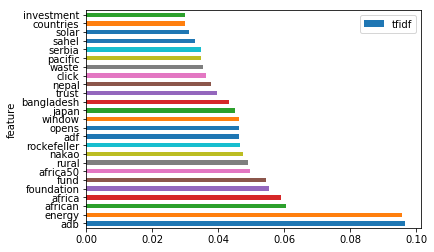

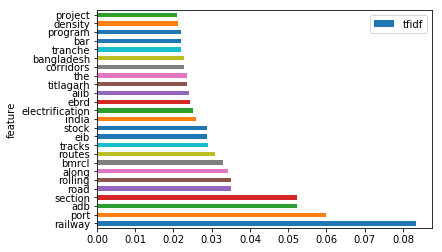

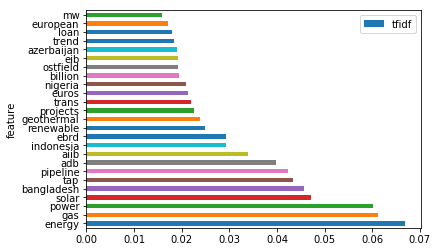

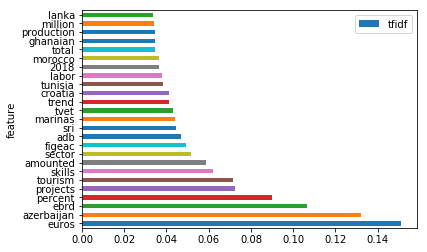

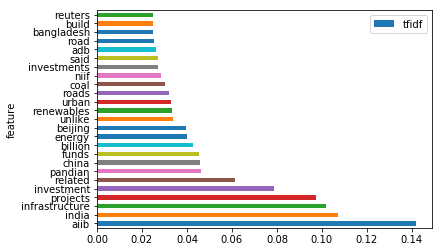

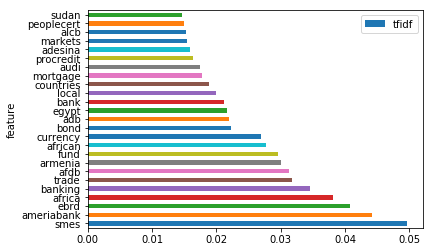

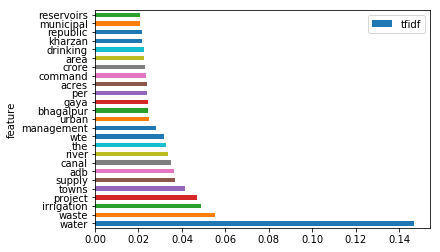

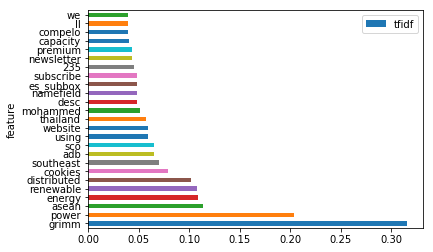

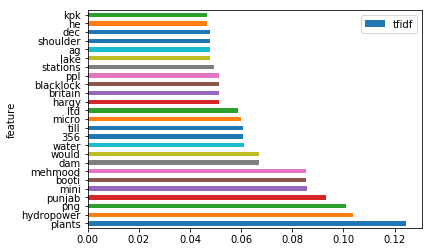

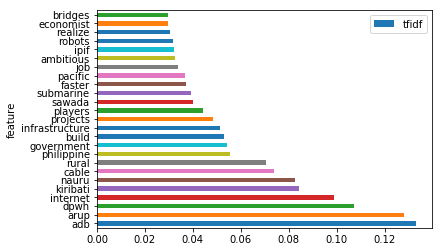

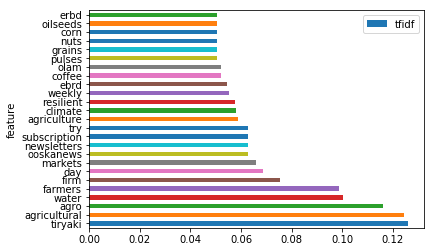

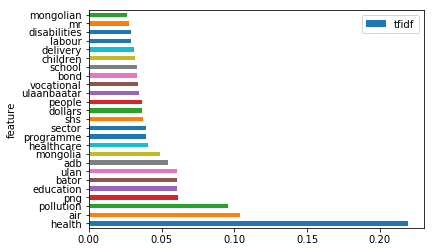

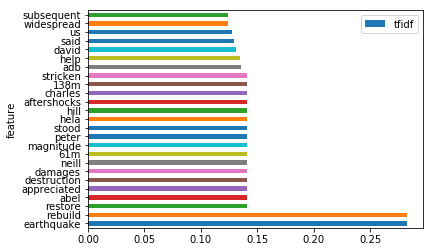

In [293]:
for sector, df in sector_dfs.items():
    print(sector)
    df.plot.barh('feature', 'tfidf')

# Actually take advantage of labeled data to train according
# to tf-idf scores

In [294]:
from sklearn.naive_bayes import MultinomialNB

dont know if keeping things categorical is great here

In [295]:
bayes_pip = Pipeline([('vec', vectorizer), ('clf', MultinomialNB())])

In [297]:
text_clf = bayes_pip.fit(train_data['article_text'], train_data['top_sector'])

In [298]:
predicted = text_clf.predict(test_data['article_keywords'].apply(
    lambda x: ' '.join(x)))

In [299]:
np.mean(predicted == test_data['top_sector'])

0.43478260869565216

In [300]:
predicted

array(['energy', 'energy', 'energy', 'energy', 'energy', 'infrastructure',
       'energy', 'energy', 'water and sanitation', 'energy', 'energy',
       'energy', 'energy', 'energy', 'energy', 'energy', 'infrastructure',
       'energy', 'energy', 'energy', 'energy', 'infrastructure', 'energy',
       'energy', 'energy', 'energy', 'energy', 'energy', 'energy',
       'energy', 'energy', 'energy', 'finance', 'energy', 'energy',
       'energy', 'energy', 'energy', 'water and sanitation', 'energy',
       'energy', 'energy', 'energy', 'energy', 'energy', 'energy'],
      dtype='<U24')

In [301]:
from sklearn import metrics

In [302]:
metrics.f1_score(test_data['top_sector'], predicted, average=None,
                labels=test_data['top_sector'].unique())

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([0.        , 0.54545455, 0.        , 0.44444444, 0.        ,
       0.        , 0.8       , 0.25      , 0.        ])

In [303]:
#labels are sorted
sorted(list(test_data['top_sector'].unique()))

['MISC',
 'communications',
 'education and health',
 'energy',
 'finance',
 'industry and trade',
 'infrastructure',
 'transport',
 'water and sanitation']

In [304]:
quick_predict = text_clf.predict(data['article_text'])

In [305]:
data['predicted_sector'] = quick_predict

In [306]:
data.to_csv('data_with_predictions.csv', index=False)

In [307]:
data.groupby('predicted_sector').size()

predicted_sector
energy                  10566
finance                    53
infrastructure             41
transport                  11
water and sanitation        3
dtype: int64

# Verification

In [ ]:
from sklearn.metrics

# K-Means clustering of texts by features??
http://i0.kym-cdn.com/entries/icons/mobile/000/008/342/ihave.jpg

In [91]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

In [96]:
svd = TruncatedSVD(len(sectors))
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

Xtr_norm = lsa.fit_transform(Xtr)

print("done in %fs" % (time() - t0))

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

print()

done in 9.145071s
Explained variance of the SVD step: 21%



In [99]:
km = KMeans(n_clusters=len(sectors), init='k-means++', max_iter=100, n_init=1,
                verbose=True)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(Xtr_norm)
print("done in %0.3fs" % (time() - t0))
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labeled_data['article_text'], km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labeled_data['article_text'], km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labeled_data['article_text'], km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labeled_data['article_text'], km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(Xtr_norm, km.labels_, sample_size=1000))

print()

print("Top terms per cluster:")

original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

terms = vectorizer.get_feature_names()
for i in range(len(sectors)):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=13, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=True)
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 66.14911487674657
start iteration
done sorting
end inner loop
Iteration 1, inertia 59.07331968624757
start iteration
done sorting
end inner loop
Iteration 2, inertia 57.5862654143493
start iteration
done sorting
end inner loop
Iteration 3, inertia 55.7103420948266
start iteration
done sorting
end inner loop
Iteration 4, inertia 54.87157378102595
start iteration
done sorting
end inner loop
Iteration 5, inertia 54.859249436187525
start iteration
done sorting
end inner loop
Iteration 6, inertia 54.83478648475717
start iteration
done sorting
end inner loop
Iteration 7, inertia 54.83478648475717
center shift 0.000000e+00 within tolerance 4.910053e-06
done in 0.023s

Homogeneity: 0.442
Complet

# Since Bayes is so poor, predict according to cluster

In [ ]:
#first, identify cluster by highest ranking sector